## CESM2 - LARGE ENSEMBLE (LENS2)

#### by Mauricio Rocha and Dr. Gustavo Marques

 - This notebook aims to plot time series and perform basic comparison statistics. 

### Imports

In [7]:
import xarray as xr
import pandas as pd
import numpy as np 
import dask
import cf_xarray
from matplotlib.ticker import MaxNLocator
import intake
import cftime
import nc_time_axis
import intake_esm
import matplotlib.pyplot as plt
import pop_tools
from dask.distributed import Client
from ncar_jobqueue import NCARCluster
import warnings, getpass, os
%matplotlib inline

### Variables

In [19]:
# Meridional Overturning Circulation 
ds_out_MOC = xr.open_dataset('/glade/scratch/mauricio/LENS2_historical_south_atlantic/MOC/MOC_stats.nc') 
# Total Surface Heat Flux
ds_out_SHF = xr.open_dataset('/glade/scratch/mauricio/LENS2_historical_south_atlantic/SHF/SHF_stats.nc')
# Sea Surface Temperature
ds_out_SST = xr.open_dataset('/glade/scratch/mauricio/LENS2_historical_south_atlantic/SST/SST_stats.nc')-273.15 # K to C
# Sensible Heat Flux
ds_out_SHFLX = xr.open_dataset('/glade/scratch/mauricio/LENS2_historical_south_atlantic/SHFLX/SHFLX_stats.nc')
# Latent Heat Flux
ds_out_LHFLX = xr.open_dataset('/glade/scratch/mauricio/LENS2_historical_south_atlantic/LHFLX/LHFLX_stats.nc')
# Heat Storage 
ds_out_HS = xr.open_dataset('/glade/scratch/mauricio/LENS2_historical_south_atlantic/HS/HS_stats.nc')
# Temperatura (atmosphere)
ds_out_T = xr.open_dataset('/glade/scratch/mauricio/LENS2_historical_south_atlantic/T/T_stats.nc').isel(lev=0)-273.15 # K to C and choose the level 
# Total Precipitation
ds_out_PRECT = xr.open_dataset('/glade/scratch/mauricio/LENS2_historical_south_atlantic/PRECT/PRECT_stats.nc')*86400000 # mm/day
# Temperature (ocean)
ds_out_TEMP = xr.open_dataset('/glade/scratch/mauricio/LENS2_historical_south_atlantic/TEMP/TEMP_stats.nc').isel(z_t=41) # choose the level
# Maximum Mixed Layer Depth
ds_out_XMXL = xr.open_dataset('/glade/scratch/mauricio/LENS2_historical_south_atlantic/XMXL/XMXL_stats.nc')*-0.01 # cm to m and negative depth

### Function to determine the ticks

In [9]:
def calculate_ticks(ax, ticks, round_to=0.01, center=False):
    upperbound = np.ceil(ax.get_ybound()[1]/round_to)
    lowerbound = np.floor(ax.get_ybound()[0]/round_to)
    dy = upperbound - lowerbound
    fit = np.floor(dy/(ticks - 1)) + 1
    dy_new = (ticks - 1)*fit
    if center:
        offset = np.floor((dy_new - dy)/2)
        lowerbound = lowerbound - offset
    values = np.linspace(lowerbound, lowerbound + dy_new, ticks)
    return values*round_to

### Plot

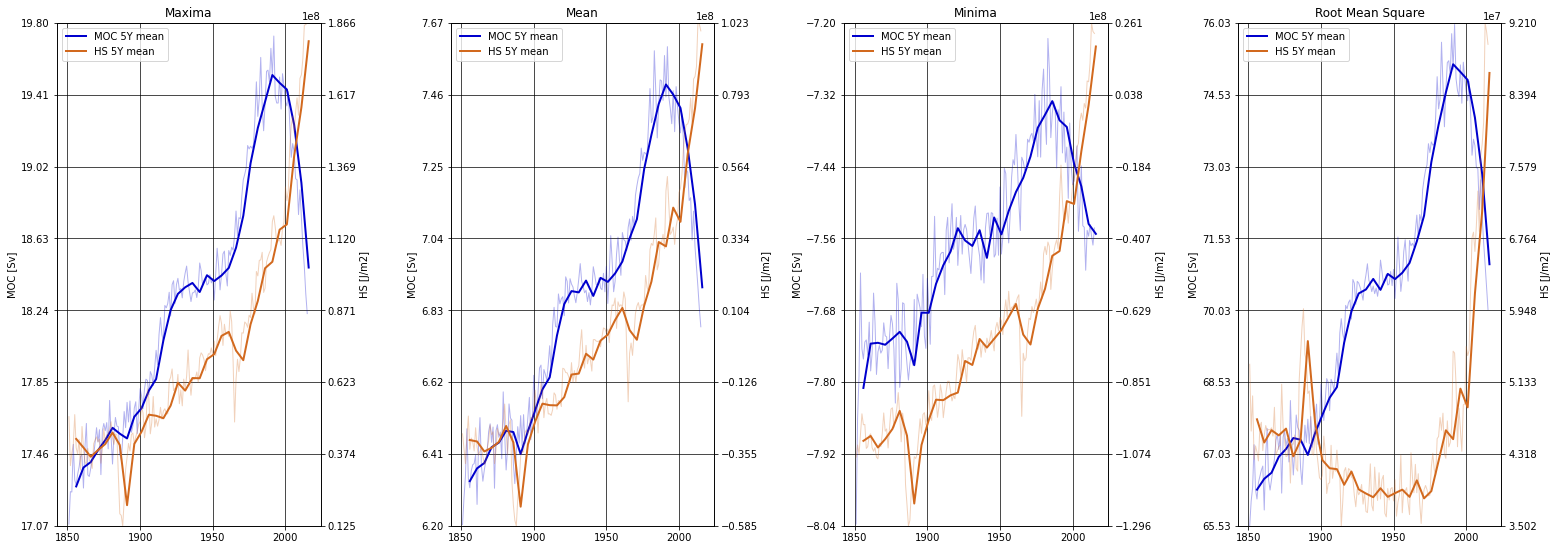

In [22]:
var=('MOC','HS') # Chose two variables  
ylabel=('MOC [Sv]','HS [J/m2]') # This is the y-labels, so do not forget to mention the unit

str=f'var1_max=ds_out_{var[0]}.{var[0]}_max; var1_mean=ds_out_{var[0]}.{var[0]}_mean; var1_min=ds_out_{var[0]}.{var[0]}_min; var1_rms=ds_out_{var[0]}.{var[0]}_rms'; exec(str)
str=f'var2_max=ds_out_{var[1]}.{var[1]}_max; var2_mean=ds_out_{var[1]}.{var[1]}_mean; var2_min=ds_out_{var[1]}.{var[1]}_min; var2_rms=ds_out_{var[1]}.{var[1]}_rms'; exec(str)
str=f'clabel=(\'{var[0]} 5Y mean\',\'{var[1]} 5Y mean\')'; exec(str)
xlabel=('Time [Years]')
nrows=1; ncols=4; height=8; width=22; alpha=0.3; pad=2

var1_colors=('mediumblue','mediumblue','mediumblue','mediumblue'); var2_colors=('chocolate','chocolate','chocolate','chocolate')

fig,ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(width,height),sharey=False)

# Max
ax[0].plot(var1_max['time'],var1_max.mean('member_id'),color=var1_colors[0],alpha=alpha,linewidth=1)
lns1 = ax[0].plot(var1_max.resample(time='5Y', closed='left').mean('time')['time'],var1_max.resample(time='5Y', closed='left').mean('time').mean('member_id'),color=var1_colors[0],linewidth=2,label=clabel[0])
ax0 = ax[0].twinx()
ax0.plot(var2_max['time'],var2_max.mean('member_id'),color=var2_colors[0],alpha=alpha,linewidth=1)
lns2 = ax0.plot(var2_max.resample(time='5Y', closed='left').mean('time')['time'],var2_max.resample(time='5Y', closed='left').mean('time').mean('member_id'),color=var2_colors[0],linewidth=2,label=clabel[1])
ax[0].grid(color='k', linestyle='-', linewidth=0.7)
ax[0].set_ylim(var1_max.mean('member_id').min(),var1_max.mean('member_id').max())
ax0.set_ylim(var2_max.mean('member_id').min(),var2_max.mean('member_id').max())
ax[0].set_yticks(calculate_ticks(ax[0], 8))
ax0.set_yticks(calculate_ticks(ax0, 8))
ax0.set_title('Maxima')
lns = lns1+lns2
labs = [l.get_label() for l in lns]
ax[0].legend(lns, labs, loc=2)
ax[0].set_ylabel(ylabel[0])
ax0.set_ylabel(ylabel[1])
ax0.set_xlabel(xlabel)
# Mean
ax[1].plot(var1_mean['time'],var1_mean.mean('member_id'),color=var1_colors[1],alpha=alpha,linewidth=1)
lns1 = ax[1].plot(var1_mean.resample(time='5Y', closed='left').mean('time')['time'],var1_mean.resample(time='5Y', closed='left').mean('time').mean('member_id'),color=var1_colors[1],linewidth=2,label=clabel[0])
ax1 = ax[1].twinx()
ax1.plot(var2_mean['time'],var2_mean.mean('member_id'),color=var2_colors[1],alpha=alpha,linewidth=1)
lns2 = ax1.plot(var2_mean.resample(time='5Y', closed='left').mean('time')['time'],var2_mean.resample(time='5Y', closed='left').mean('time').mean('member_id'),color=var2_colors[1],linewidth=2,label=clabel[1])
ax[1].grid(color='k', linestyle='-', linewidth=0.7)
ax[1].set_ylim(var1_mean.mean('member_id').min(),var1_mean.mean('member_id').max())
ax1.set_ylim(var2_mean.mean('member_id').min(),var2_mean.mean('member_id').max())
ax[1].set_yticks(calculate_ticks(ax[1], 8))
ax1.set_yticks(calculate_ticks(ax1, 8))
ax1.set_title('Mean')
lns = lns1+lns2
labs = [l.get_label() for l in lns]
ax[1].legend(lns, labs, loc=2)
ax[1].set_ylabel(ylabel[0])
ax1.set_ylabel(ylabel[1])
ax1.set_xlabel(xlabel)
# Min
ax[2].plot(var1_min['time'],var1_min.mean('member_id'),color=var1_colors[2],alpha=alpha,linewidth=1)
lns1 = ax[2].plot(var1_min.resample(time='5Y',closed='left').mean('time')['time'],var1_min.resample(time='5Y', closed='left').mean('time').mean('member_id'),color=var1_colors[2],linewidth=2,label=clabel[0])
ax2 = ax[2].twinx()
ax2.plot(var2_min['time'],var2_min.mean('member_id'),color=var2_colors[2],alpha=alpha,linewidth=1)
lns2 = ax2.plot(var2_min.resample(time='5Y', closed='left').mean('time')['time'],var2_min.resample(time='5Y', closed='left').mean('time').mean('member_id'),color=var2_colors[2],linewidth=2,label=clabel[1])
ax[2].grid(color='k', linestyle='-', linewidth=0.7)
ax[2].set_ylim(var1_min.mean('member_id').min(),var1_min.mean('member_id').max())
ax2.set_ylim(var2_min.mean('member_id').min(),var2_min.mean('member_id').max())
ax[2].set_yticks(calculate_ticks(ax[2], 8))
ax2.set_yticks(calculate_ticks(ax2, 8))
ax2.set_title('Minima')
lns = lns1+lns2
labs = [l.get_label() for l in lns]
ax[2].legend(lns, labs, loc=2)
ax[2].set_ylabel(ylabel[0])
ax2.set_ylabel(ylabel[1])
ax2.set_xlabel(xlabel)
# Error
ax[3].plot(var1_rms['time'],var1_rms.mean('member_id'),color=var1_colors[3],alpha=alpha,linewidth=1)
lns1 = ax[3].plot(var1_rms.resample(time='5Y', closed='left').mean('time')['time'],var1_rms.resample(time='5Y', closed='left').mean('time').mean('member_id'),color=var1_colors[3],linewidth=2,label=clabel[0])
ax3 = ax[3].twinx()
ax3.plot(var2_rms['time'],var2_rms.mean('member_id'),color=var2_colors[3],alpha=alpha,linewidth=1)
lns2 = ax3.plot(var2_rms.resample(time='5Y', closed='left').mean('time')['time'],var2_rms.resample(time='5Y', closed='left').mean('time').mean('member_id'),color=var2_colors[3],linewidth=2,label=clabel[1])
ax[3].grid(color='k', linestyle='-', linewidth=0.7)
ax[3].set_ylim(var1_rms.mean('member_id').min(),var1_rms.mean('member_id').max())
ax3.set_ylim(var2_rms.mean('member_id').min(),var2_rms.mean('member_id').max())
ax[3].set_yticks(calculate_ticks(ax[3], 8))
ax3.set_yticks(calculate_ticks(ax3, 8))
ax3.set_title('Root Mean Square')
lns = lns1+lns2
labs = [l.get_label() for l in lns]
ax[3].legend(lns, labs, loc=2)
ax[3].set_ylabel(ylabel[0])
ax3.set_ylabel(ylabel[1])
ax3.set_xlabel(xlabel)
fig.tight_layout(pad=pad)
plt.show()